In [1]:
import xarray as xr
import numpy as np
import xroms
import matplotlib.pyplot as plt
import sys
sys.path.append('/scratch/ss4338/2020/')
from track import track
from Interpolation import interpolation

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [318]:
# accessing dataset
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
chunk = {"ocean_time":50}
ds = xroms.open_netcdf(link, chunks=chunk)
lonModel = ds.lon_rho
latModel = ds.lat_rho


In [319]:
import netCDF4 as nc
#lat = xr.open_dataset('frc_watl_ERA5_allflux_201901.nc', variables=['lon','lat'])
era5 = nc.Dataset('frc_watl_ERA5_allflux_201901.nc')
lat = era5.variables['lat'][:]
lon = era5.variables['lon'][:]
lat.shape

eradata = xr.open_dataset('frc_watl_ERA5_allflux_202005.nc', drop_variables=['lon','lat'])

lat = lat[:,0]

lon = lon[0,:]

airsea = eradata.shflux.assign_coords(lat=lat, lon=lon)

lat_min = latModel.min().values
lat_max = latModel.max().values

# Correctly applying the logical condition
condition = (lat_min <= lat) & (lat <= lat_max)

# Using np.where
lat_indices = np.where(condition)
lat_indices = lat_indices[0]

lon_min, lon_max = lonModel.min().values, lonModel.max().values

condition = (lon_min <= lon) & (lon_max >= lon)
lon_indices = np.where(condition)
lon_indices = lon_indices[0]

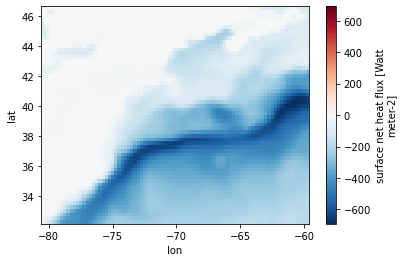

In [289]:

(airsea.isel(lat = lat_indices, lon=lon_indices).mean(dim='time')).plot()

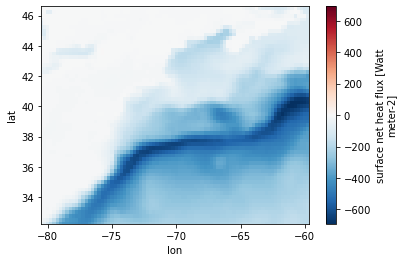

In [290]:
(airsea.mean(dim='time')).plot(xlim=[lonModel.min().values, lonModel.max().values],ylim=[latModel.min().values, latModel.max().values])

# interpolation on era5 grid

In [90]:
lon1d, lat1d = lonModel[:].values.flatten(), latModel[:].values.flatten()

In [94]:
lon_era5, lat_era5 = lon[lon_indices], lat[lat_indices]

In [259]:
combined = (np.hstack((lon1d[:, np.newaxis],lat1d[:, np.newaxis])))
np.shape(combined)

(25652, 2)

In [301]:
grid_x, grid_y = np.meshgrid(lon_era5, lat_era5)

In [324]:
start_time = '2020-05-01'
end_time = '2020-05-31'

ds = ds.sel(ocean_time=slice(start_time,end_time))

shflux = ds.shflux.mean(dim='ocean_time')
mask = np.isnan(shflux.values.ravel())
test = shflux.values.ravel()

from scipy.interpolate import griddata
shflux_interp = griddata(combined[~mask], test[~mask], (grid_x, grid_y), method='linear')
# mask_interp = griddata(combined[~mask], ds.mask_rho.values.ravel()[~mask], (grid_x, grid_y), method='linear')

plt.contourf(lon_era5,lat_era5,shflux_interp, cmap='RdBu_r')

# interpolation region mask on era5 grid

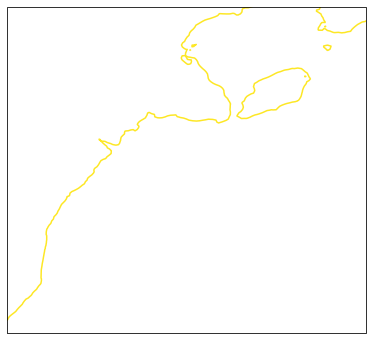

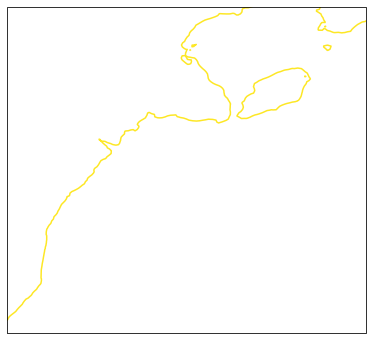

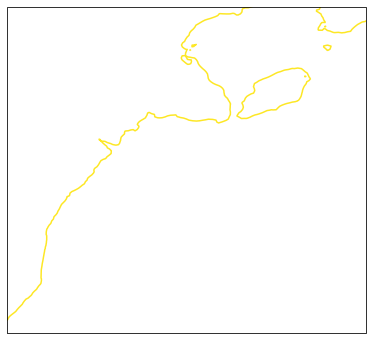

In [203]:
bathymetry = ds.h

extent = [-76,-65, 34, 44]
sigma = 15
lon_left = -75
lon_right = -70.65
isobath_value = 65
track_coords = track(ds, bathymetry, extent, lon_left, lon_right, isobath_value, sigma)

AB_lon_lat, AB_ij = track_coords.AB_track(-0.74,50);
CD_lon_lat, CD_ij = track_coords.CD_track( 0.32,50);
BC_lon_lat, BC_ij = track_coords.BC_track();

final_ij_isobath = np.vstack((AB_ij[::-1], BC_ij, CD_ij))

final_lon_lat = np.vstack((AB_lon_lat[::-1], BC_lon_lat, CD_lon_lat))



In [204]:
x1,y1 = AB_ij[0]
x2,y2 = AB_ij[-1]

m = (y2-y1)/(x2-x1)
y = y2-m*x2

In [205]:
x1,y2 = CD_ij[0]
x2,y2 = CD_ij[-1]

m = (y2-y1)/(x2-x1)
x = (106 - y2)/m + x2

In [206]:
vertices1 = (0, y)  
vertices2 = (x,106)


import matplotlib.path as mpath

def create_mask(shape, polygon):
    y,x = np.mgrid[:shape[0], :shape[1]]
    points = np.column_stack((x.ravel(), y.ravel()))
    path = mpath.Path(polygon)
    mask = path.contains_points(points).reshape(shape)
    
    return mask

shape = (106, 242)
polygon = np.vstack((vertices1, final_ij_isobath, vertices2))
# polygon = final_ij_isobath


reg_mask = create_mask(shape, polygon)
new_mask = (ds.mask_rho*reg_mask)

In [208]:
new_mask = new_mask.values.ravel()

reg_mask_interp = griddata(combined[~mask], new_mask[~mask], (grid_x, grid_y), method='linear')

reg_mask_interp = np.nan_to_num(reg_mask_interp)

plt.contourf(reg_mask_interp)

In [221]:
area = ds.dA.values.ravel()
interp_area = griddata(combined[~mask], area[~mask], (grid_x, grid_y), method='linear')

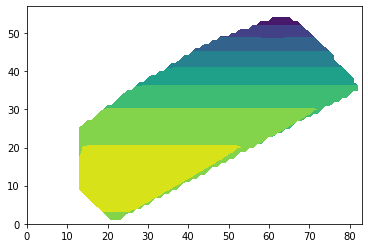

In [224]:
plt.contourf(interp_area)

In [228]:
(np.nan_to_num(interp_area*reg_mask_interp)).sum()

13156817952.282742

In [233]:
final_area = np.nan_to_num(interp_area*reg_mask_interp)

# Heat tarnsport in the desired region

In [327]:
final_shflux = np.nan_to_num(shflux_interp*reg_mask_interp)

In [328]:
heat_2020_5 = (final_shflux*final_area).sum()

In [239]:
heat_2020_1

-811438114585.612

In [286]:
heat_2020_3

683347197811.0126

In [313]:
heat_2020_4

871227256587.7422

In [329]:
heat_2020_5

1303196321102.9043

In [330]:
heatera5 = np.nan_to_num(((airsea.isel(lat = lat_indices, lon=lon_indices).mean(dim='time')).values)*interp_area*reg_mask_interp).sum()

In [331]:
heatera5

1206179279772.935

In [293]:
((heatera5 - heat_2020_1)/heatera5)*100

-37.356862861473914

In [297]:
((heatera5 - heat_2020_3)/heatera5)*100

-15.318523093518197

In [317]:
((heatera5 - heat_2020_4)/heatera5)*100

-22.96737428338049

In [332]:
((heatera5 - heat_2020_5)/heatera5)*100

-8.04333509594302

# Net Heat transport in the region from era5 dataset

In [353]:
index = range(1,13)

era5_data_2020 = []
for i in index:
    airsea = xr.open_dataset(f'frc_watl_ERA5_allflux_2020{i:02d}.nc', drop_variables=['lat','lon'])
    airsea = airsea.shflux.assign_coords(lat = lat, lon = lon)
    heat = np.nan_to_num(((airsea.isel(lat = lat_indices, lon=lon_indices).mean(dim='time')).values)*interp_area*reg_mask_interp).sum()
    era5_data_2020.append(heat)


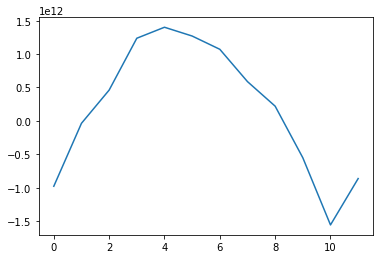

In [350]:
plt.plot(era5_data_2019)

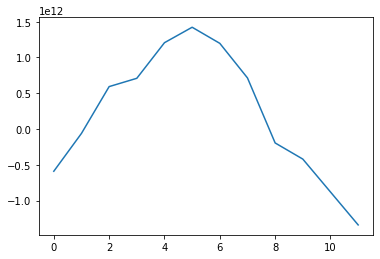

In [354]:
plt.plot(era5_data_2020)

In [363]:
era5_heat = np.hstack((era5_data_2019, era5_data_2020))

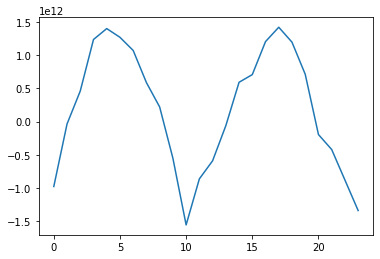

In [365]:
plt.plot(era5_heat)

In [371]:
start = '2019'
end = '2022'
link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
chunk = {"ocean_time":50}
ds = xroms.open_netcdf(link, chunks=chunk)

ds = ds.sel(ocean_time=slice(start,end))
ds = ds.resample(ocean_time='M').mean(dim='ocean_time')

In [ ]:


link = "https://tds.marine.rutgers.edu/thredds/dodsC/roms/doppio/DopAnV3R3-ini2007_da/avg"
chunk = {"ocean_time":50}
ds = xroms.open_netcdf(link, chunks=chunk)
ds = ds.sel(ocean_time=slice(start_time,end_time))

shflux = ds.shflux.mean(dim='ocean_time')
mask = np.isnan(shflux.values.ravel())
test = shflux.values.ravel()

from scipy.interpolate import griddata
shflux_interp = griddata(combined[~mask], test[~mask], (grid_x, grid_y), method='linear')
# mask_interp = griddata(combined[~mask], ds.mask_rho.values.ravel()[~mask], (grid_x, grid_y), method='linear')

final_shflux = np.nan_to_num(shflux_interp*reg_mask_interp)
heat_2020_5 = (final_shflux*final_area).sum()

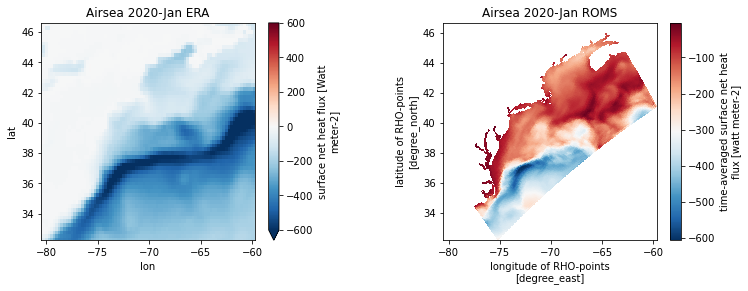

In [190]:
airsea2020 = xr.open_dataset('frc_watl_ERA5_allflux_202001.nc', drop_variables=['lon','lat'])
airsea2020 = airsea2020.shflux.assign_coords(lat=lat, lon=lon)

start_time = '2020-01-01'
end_time = '2020-01-31'

ds = (ds).sel(ocean_time=slice(start_time, end_time))

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
(airsea2020.mean(dim='time')).plot(ax=axes[0], vmin = -600, xlim=[lonModel.min().values, lonModel.max().values],ylim=[latModel.min().values, latModel.max().values], cmap='RdBu_r')
axes[0].set_title('Airsea 2020-Jan ERA')

(ds.shflux.mean(dim='ocean_time')).cf.plot(ax=axes[1], cmap='RdBu_r')
axes[1].set_title('Airsea 2020-Jan ROMS')
plt.subplots_adjust(wspace=0.5)
plt.tight_layout
plt.show()

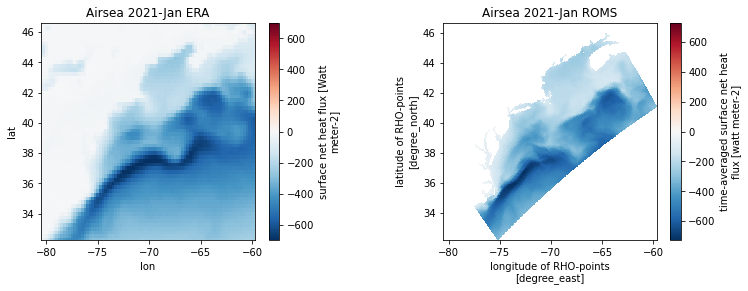

In [184]:
airsea2021 = xr.open_dataset('frc_watl_ERA5_allflux_202101.nc', drop_variables=['lon','lat'])
airsea2021 = airsea2021.shflux.assign_coords(lat=lat, lon=lon)

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
(airsea2021.mean(dim='time')).plot(ax=axes[0], xlim=[lonModel.min().values, lonModel.max().values],ylim=[latModel.min().values, latModel.max().values], cmap='RdBu_r')
axes[0].set_title('Airsea 2021-Jan ERA')

(ds.shflux.mean(dim='ocean_time')).cf.plot(ax=axes[1], cmap='RdBu_r')
axes[1].set_title('Airsea 2021-Jan ROMS')
plt.subplots_adjust(wspace=0.5)
plt.tight_layout
plt.show()